# PyPerceive to select and load Percept recordings 

## 0a. Loading default packages and functions

In [1]:
# Importing Python and external packages
import os
import sys
import pandas as pd
import numpy as np
import importlib

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## 0b. Loading pyPerceive functions

In [2]:
def add_and_set_code_folder_in_notebook():
    """
    while working in the local pyPerceive repo,
    find and set path to the PyPerceive code folder

    use function in notebook first, to locate the local
    repo and enable import of pyPerceive functions
    """
    project_path = os.getcwd()

    while project_path[-10:] != 'PyPerceive':
        project_path = os.path.dirname(project_path)

    code_path = os.path.join(project_path, 'code')
    sys.path.append(code_path)

    # change directory to code path
    os.chdir(code_path)
    
    return print(f'working dir set to: {code_path}')


In [3]:
## MAIN FUNCTION FOR DATA IMPORT

# change working directory to ensure correct loading of own functions
add_and_set_code_folder_in_notebook()

# import main class to work with
from PerceiveImport.classes import main_class


working dir set to: c:\Users\habetsj\Research\projects\PyPerceive\code


In [4]:
## IMPORT ALL SUB CLASSES AND FUNCTIONS FOR DEBUGGING
from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class, chronic_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#### Function created for stim-detection

In [5]:
# import functions for find_LFP_sync_artefact()
from scipy.signal import find_peaks
from itertools import compress

In [219]:
def find_LFP_sync_artefact(
    lfp_data: np.ndarray, fs: int = 250,
    use_kernel: str = '1',
    consider_first_seconds=None,
):
    """
    Function that finds artefacts caused by
    switching stimulation on and off.
    For correct functioning, the LFP dat should
    start in stim-off, and typically short pulses
    are given (without ramping).
    The function uses a kernel which mimics the stimulation-
    artefact. This kernel is multiplied with time-series
    snippets of the same length. If the time-serie is
    similar to the kernel, the dot-product is high, and this
    indicates a stim-artefact.

    Input:
        - lfp_data: single channel as np.ndarray (the function
            automatically inverts the signal if first a positive
            peak is found, this indicates an inverted signal)
        - fs: sampling frequency
        - use_kernel: decides whether kernel 1 or 2 is used,
            kernel 1 is straight-forward and finds a steep decrease,
            kernel 2 mimics the steep decrease and slow
            recovery of the signal.
        - consider_first_seconds: if given, only artefacts in the first
            (and last) n-seconds are considered
    
    Returns:
        - list of idx: a list with all stim-artefact starts. This
            also contains stim-artefacts not happening at the
            beginning or end of the recording. These have to be
            selected by the user afterwards.
    """
    signal_inverted = False  # defaults false

    # checks correct input for use_kernel variable
    assert use_kernel in ['1', '2'], 'use_kernel incorrect'

    # kernel 1 only searches for the steep decrease
    # kernel 2 is more custom and takes into account the steep decrease and slow recover
    kernels = {'1': np.array([1, -1]),
               '2': np.array([1, 0, -1] + list(np.linspace(-1, 0, 20)))}
    ker = kernels[use_kernel]
    
    # get dot-products between kernel and time-serie snippets
    res = []  # store results of dot-products
    for i in np.arange(0, len(lfp_data) - len(ker)):
        res.append(ker @ lfp_data[i:i+len(ker)])  # calculate dot-product of vectors
        # the dot-product result is high when the timeseries snippet
        # is very similar to the kernel
    res = np.array(res)  # convert list to array

    # # normalise dot product results
    res = res / max(res)

    # calculate a ratio between std dev and maximum during
    # the first seconds to check whether an stim-artef was present 
    ratio_max_sd = np.max(res[:fs*30] / np.std(res[:fs*5]))
    
    # use peak of kernel dot products    
    pos_idx = find_peaks(x=res, height=.3 * max(res),
                        distance=fs)[0]
    neg_idx = find_peaks(x=-res, height=-.3 * min(res),
                        distance=fs)[0]
    
    # check whether signal is converted
    if neg_idx[0] < pos_idx[0]:
        # the first peak should be POSITIVE (this is for the dot-product results)
        # actual signal is first peak negative
        # if NEG peak before POS then signal is inverted
        print('signal is inverted')
        signal_inverted = True
        print(pos_idx[0], neg_idx[0])
        # re-check inverted for difficult cases with small pos-lfp peak before negative stim-artefact
        if (pos_idx[0] - neg_idx[0]) < 50:  # if first positive and negative are very close
            width_pos = 0
            r_i = pos_idx[0]
            while res[r_i] > (max(res) * .3):
                r_i += 1
                width_pos += 1
            width_neg = 0
            r_i = neg_idx[0]
            while res[r_i] < (min(res) * .3):
                r_i += 1
                width_neg += 1
            # undo invertion if negative dot-product (pos lfp peak) is very narrow
            if width_pos > (2 * width_neg):
                signal_inverted = False
                print('invertion undone')
            
            

    # return either POS or NEG peak-indices based on normal or inverted signal
    if not signal_inverted:
        stim_idx = pos_idx  # this is for 'normal' signal

    elif signal_inverted:
        stim_idx = neg_idx
    

    # check warn if NO STIM artefacts are suspected
    if len(stim_idx) > 20 and ratio_max_sd < 8:
        print('WARNING: probably the LFP signal did NOT'
              ' contain any artefacts. Many incorrect timings'
              ' could be returned')


    if consider_first_seconds:
        border_start = fs*consider_first_seconds
        border_end = len(lfp_data) - (fs * consider_first_seconds)
        sel = np.logical_or(np.array(stim_idx) < border_start,
                             np.array(stim_idx) > border_end)
        stim_idx = list(compress(stim_idx, sel))


    # filter out inconsistencies in peak heights (assuming sync-stim-artefacts are stable)
    abs_heights = [max(abs(lfp_data[i-5:i+5])) for i in stim_idx]
    diff_median = np.array([abs(p - np.median(abs_heights)) for p in abs_heights])
    sel_idx = diff_median < (np.median(abs_heights) * .66)
    stim_idx = list(compress(stim_idx, sel_idx))
    # check polarity of peak
    if not signal_inverted:
        sel_idx = np.array([min(lfp_data[i-5:i+5]) for i in stim_idx]) < (np.median(abs_heights) * -.5)
    elif signal_inverted:
        sel_idx = np.array([max(lfp_data[i-5:i+5]) for i in stim_idx])  > (np.median(abs_heights) * .5)
    stim_idx = list(compress(stim_idx, sel_idx))


    return stim_idx


## 1. Data Loading for Streaming and Survey

In [14]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

importlib.reload(task_class)

norm = main_class.PerceiveData(
    sub = "020", 
    incl_modalities=['streaming',],
    incl_session = ["fu23m", 'fu3m'],
    incl_condition =['m1s0', 'm0s0', 'm1s1'],
    incl_task = ["rest"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=True
)



add run 1
Creating RawArray with float64 data, n_channels=6, n_times=41375
    Range : 0 ... 41374 =      0.000 ...   165.496 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=44625
    Range : 0 ... 44624 =      0.000 ...   178.496 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=59500
    Range : 0 ... 59499 =      0.000 ...   237.996 secs
Ready.
inserted session (fu3m, streaming) can not be found in the metadata table


In [7]:

trouble = main_class.PerceiveData(
    sub = "059", 
    incl_modalities=['streaming',],
    incl_session = ["fu3m"],
    incl_condition =['m1s0', 'm1s1', 'm0s0'],
    incl_task = ["rest"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=True
)

add run 1
Creating RawArray with float64 data, n_channels=6, n_times=62625
    Range : 0 ... 62624 =      0.000 ...   250.496 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=46563
    Range : 0 ... 46562 =      0.000 ...   186.248 secs
Ready.
add run 2
Creating RawArray with float64 data, n_channels=6, n_times=65937
    Range : 0 ... 65936 =      0.000 ...   263.744 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=5250
    Range : 0 ... 5249 =      0.000 ...    20.996 secs
Ready.
add run 2
Creating RawArray with float64 data, n_channels=6, n_times=6625
    Range : 0 ... 6624 =      0.000 ...    26.496 secs
Ready.
add run 3
Creating RawArray with float64 data, n_channels=6, n_times=55187
    Range : 0 ... 55186 =      0.000 ...   220.744 secs
Ready.


normal example

In [24]:
first_pos_peak = np.where(lfp_sig > max(lfp_sig) * .5)[0][0]
first_neg_peak = np.where(lfp_sig < min(lfp_sig) * .5)[0][0]

print(first_neg_peak, first_pos_peak)

1601 2036


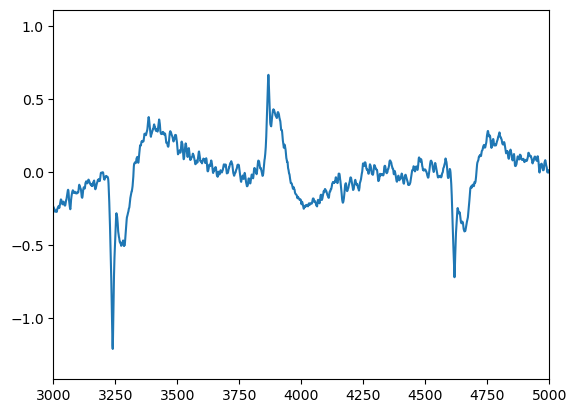

[ 1599  2186  2802  3384  3867 37989 38428 38774 39908 40578]
[ 2034  3239  4617 38233 39263 40432]
[ True  True  True  True  True  True  True  True  True  True]
[ True False  True False  True  True False  True  True False]
[1599, 2802, 3867, 37989, 38774, 39908]


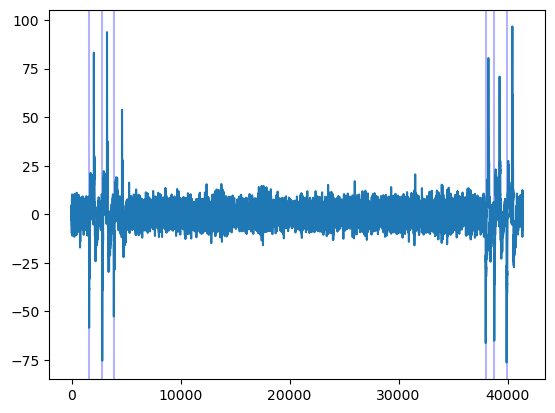

In [205]:
# define data
normdata = norm.streaming.fu23m.m1s0.rest.run1.data
ch_i = 0
lfp_sig = normdata.get_data()[ch_i]
# get stim-artefact indices
art_idx = find_LFP_sync_artefact(
    lfp_data=lfp_sig, fs=250,
    use_kernel='2',
    consider_first_seconds=60
)
print(art_idx)
for xline in art_idx:
    plt.axvline(x=xline, ymin=min(lfp_sig), ymax=max(lfp_sig),
                color='blue', alpha=.3,)

plt.plot(lfp_sig)

# plt.xlim(1000, 5000)
# plt.xlim(37000, 42000)
plt.show()

difficult example

In [ ]:
# check amplitudes of maximum peaks present in first minute
# then define which max peak to use

use channel: LFP_L_02_STN_MT
signal is inverted
5721 4611
[ True  True  True]
[ True  True  True]
[4611, 6915, 8869]


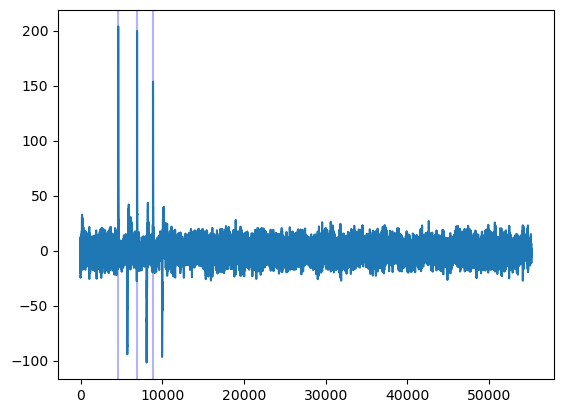

In [216]:
# define data
data = trouble.streaming.fu3m.m0s0.rest.run3.data
# data = trouble.streaming.fu3m.m1s0.rest.run1.data
# data = trouble.streaming.fu3m.m1s1.rest.run2.data
ch_i = 0
lfp_sig = data.get_data()[ch_i]
print(f'use channel: {data.ch_names[ch_i]}')

# get stim-artefact indices
art_idx = find_LFP_sync_artefact(
    lfp_data=lfp_sig, fs=250,
    use_kernel='2',
    consider_first_seconds=40
)
print(art_idx)
for xline in art_idx:
    plt.axvline(x=xline, ymin=min(lfp_sig), ymax=max(lfp_sig),
                color='blue', alpha=.3,)

plt.plot(lfp_sig)

# plt.xlim(3000, 5000)
# plt.xlim(60000, 65000)
plt.show()


inverted data example

In [47]:
inv = main_class.PerceiveData(
    sub = "019", 
    incl_modalities=['streaming',],
    incl_session = ["fu24m"],
    incl_condition =['m1s1'],
    incl_task = ["fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
)



	### WARNING: NaNs in Metadata Table sub-019 ###
NaNs in: sub019_ses-2021042207162599_run-BrainSense20210422074600.mat
NaNs in: sub019_ses-2021042207162599_run-BrainSense20210422075600.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081000.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081300.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081500.mat
NaNs in: sub019_ses-2021042207162599_run-IS20210422081900.mat
NaNs in: sub019_ses-2021070506275097_run-BrainSense20210705070700.mat
NaNs in: sub019_ses-2021070506275097_run-BrainSense20210705072100.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705074000.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705074300.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705075000.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705075800.mat
NaNs in: sub019_ses-2021070507365797_run-BrainSense20210705081000.mat
NaNs in: sub019_ses-2021070508345297_run-BrainSense20210705084300.mat
Na

signal is inverted
1720 1074
[ True  True  True False  True  True  True]
[ True  True  True  True  True  True]
[1074, 2426, 3650, 47806, 49344, 50660]


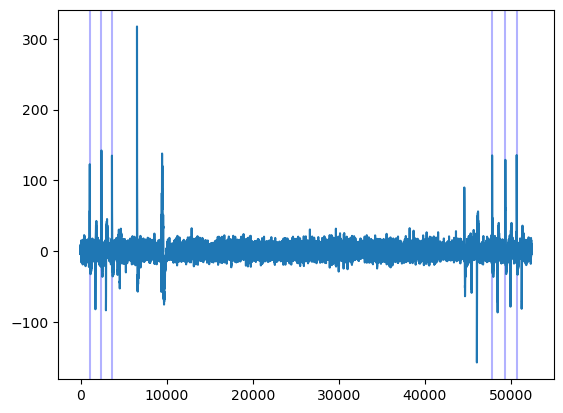

In [214]:
# define lfp data
invdata = inv.streaming.fu24m.m1s1.fingerTap.run1.data
ch_i = 1
lfp_sig = invdata.get_data()[ch_i]

# get stim-artefact indices
art_idx = find_LFP_sync_artefact(
    lfp_data=lfp_sig, fs=250,
    use_kernel='2',
    consider_first_seconds=30
)

print(art_idx)
for xline in art_idx:
    plt.axvline(x=xline, ymin=min(lfp_sig), ymax=max(lfp_sig),
                color='blue', alpha=.3,)

plt.plot(lfp_sig)

# plt.xlim(2000, 11000)

plt.show()